# Project 5: Image Reconstruction with Convolutional Autoencoders (Conv AEs)

Description:

Autoencoders (AEs) are a self-supervised approach to extracting useful compressed representation of data. They are being used in many different deep learning contexts and especially in Computer Vision for applications such as denosining and in general for transfer learning. A new divide of the AE’s, so-called variational AEs (VAEs), are nowadays considered a generative model next to GANs. The goal of this exercise is to use your learnings from the ML Course EE468 to:

1. Build a simple pipeline to load and preprocess your input images if needed, and train a convolutional AE (Conv AE) on Fashion MNIST (FMNIST) dataset. Use the links provided below to see samples of different convolutional architectures (encdoer and decoder) people have used before, but be innovative and use your learnings from the course to explore different architectures, and components, to hopefully land on the best architecture! Note: you don’t need to pick a huge encoder/decoder model.
2. As part of this exercise, visualize the reconstruction error/loss throughout the training, as well as a few samples of the reconstructed test images.
3. Make sure you pipeline saves the best model according to the loss value. You need to save the so-called “checkpoint” (ckpt) files. It never hurts to save the last model too!
4. You essentially don’t need the labels (self-supervised learning!) but use them for your visualizations to see if the reconstructed images match the labels.
5. Note: there are two schools of thought for the type of loss function you can use, i) cross-entropy loss, ii) mean squared error loss. The choice is yours unless you have to go for one, for instance, because of your data and preprocessing strategy. Explain which one you opted and why.
6. Repeat the same exercise for CIFAR10. Don’t forget that now you have 3 input channels. Do you find CIFAR10 a more difficult dataset to obtain a good reconstruction quality, or an easier one? Make your encoder/decoder architecture a bit more complex if need be, and explain your strategy.
7. Edit your model to also return the latent embedding besides the reconstructed image. Make sure your “bottleneck layer” is fully-connected (not convolutional) for this part. How did you choose the size (number of neurons) of this bottleneck layer?
8. Scatter plot these embeddings in two-dimensional (2D). Obviously, unless the size of the bottleneck layer is 2, 2D plots don’t make sense! How can you use a dimensionality reduction technique to get a 2D representation of these embeddings? What would be your choice? Consider PCA, tSNE! If you look for something even more interesting, study and employ unified manifold approximation (UMAP). They’re shown to be even better than tSNE. See the link below.
9. What happens if you plot these embeddings based on the associated labels in different colors? Will they be clustered according to the label? Feel free to add a simple clustering approach before using tSNE (or UMAP). Explain your understanding.
Dataset:

We will use the following datasets. They are both images of size 28 by 28 pixels. However, Fashion MNIST (FMNIST) is grayscale (1 input channel) while CIFAR10 is colored (3 input channels for Red, Green and Blue). FMNIST has 60,000 images for training and 10,000 for testing and CIFAR10 has 50,000 for training and 10,000 for testing. This is your choice to have a validation set split from the training set. Below you can find the link to the datasets, even though bear in mind that these datasets are super standard and both Pytorch and Keras/TF have dataloaders for immediately loading them.

Fashion MNIST (FMNIST): Labels 0-9 corresponds to the following categories:

0:tshirt 1:trouser, 2:pullover, 3:dress, 4:coat, 5:sandal, 6:shirt, 7:sneaker, 8:bag, 9:ankle boot

CIFAR10: Labels 0-9 corresponds to the following categories:

0:airplane, 1:automobile, 2:bird, 3:cat, 4:deer, 5:dog, 6:frog, 7:horse, 8:ship, 9:truck

For more information, code, and data, we refer you to:

https://www.kaggle.com/residentmario/autoencoders

https://www.cs.toronto.edu/~kriz/cifar.html

https://github.com/zalandoresearch/fashion-mnist

https://www.kaggle.com/robinteuwens/anomaly-detection-with-auto-encoders

https://umap-learn.readthedocs.io/en/latest/basic_usage.html

# Fashion MNIST: Latent dimensions vs loss

## Preprocessing

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

In [2]:
# @title reproducibility stuff
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)


torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact (reproducible)
torch.backends.cudnn.benchmark = False # find the optimal algorithm, but may lead to performance issues

In [3]:
# Define hyperparameters

Latent_dim = 128 # dim of latent space
batch_size = 128
learning_rate = 1e-3
use_gpu = True

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")


# Data loading
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST, MNIST


img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=max(10000, batch_size), shuffle=True)

# train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
# test_dataloader = DataLoader(test_dataset, batch_size=max(10000, batch_size), shuffle=True)

## Autoencoders

### Conv AE for Fashion MNIST

In [4]:
class conv_Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(conv_Encoder,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 12, 4, stride=2, padding=1),  # Output size: [batch, 12, 14, 14]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # Output size: [batch, 24, 7, 7]
            nn.ReLU(),
            nn.Conv2d(24, 48, 3, stride=2, padding=1),  # Output size: [batch, 48, 4, 4]
            nn.ReLU(),
            nn.Flatten(),  # Flatten to [batch, 8*4*4]
            nn.Linear(48*4*4, latent_dim),  # Map to latent space
            # nn.Linear(),  # Map to latent space
            # nn.ReLU()  # Optional
        )


    def forward(self,x):
        x = x.view(-1,1,28,28)
        output = self.network(x)
        return output

class conv_Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(conv_Decoder,self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 48*4*4),
            nn.ReLU()
        )

        self.network = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 3,stride=2, padding=1), # [batch, 24, 7, 7]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4,stride=2, padding=1), # [batch, 12, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 1, 4, stride=2, padding=1), # [batch, 1, 28, 28]
            # nn.ReLU(),
            # nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1), # [batch, 1, 28, 28]
            nn.Sigmoid(), # output values in [0, 1]
            # nn.ReLU()
        )


    def forward(self,x):
        x = self.linear(x)
        x = x.view(-1,48,4,4)
        output = self.network(x)
        return output


class conv_AutoEncoder(nn.Module):

    def __init__(self,latent_dim):
        super(conv_AutoEncoder, self).__init__()
        self.encoder = conv_Encoder(latent_dim)
        self.encoder.to(device)
        self.decoder = conv_Decoder(latent_dim)
        self.decoder.to(device)

    def forward(self, x):
        return self.decoder(self.encoder(x))
conv_AE = conv_AutoEncoder(latent_dim=Latent_dim).to(device)
criterion_conv_AE = nn.BCELoss()
optimizer_conv_AE = torch.optim.Adam(conv_AE.parameters(), lr=0.001)

### Conv AE model info

In [5]:
from torchsummary import summary
# summary(model,(1,16))
summary(conv_AE,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─conv_Encoder: 1-1                      [-1, 128]                 --
|    └─Sequential: 2-1                   [-1, 128]                 --
|    |    └─Conv2d: 3-1                  [-1, 12, 14, 14]          204
|    |    └─ReLU: 3-2                    [-1, 12, 14, 14]          --
|    |    └─Conv2d: 3-3                  [-1, 24, 7, 7]            4,632
|    |    └─ReLU: 3-4                    [-1, 24, 7, 7]            --
|    |    └─Conv2d: 3-5                  [-1, 48, 4, 4]            10,416
|    |    └─ReLU: 3-6                    [-1, 48, 4, 4]            --
|    |    └─Flatten: 3-7                 [-1, 768]                 --
|    |    └─Linear: 3-8                  [-1, 128]                 98,432
├─conv_Decoder: 1-2                      [-1, 1, 28, 28]           --
|    └─Sequential: 2-2                   [-1, 768]                 --
|    |    └─Linear: 3-9                  [-1, 768]                 99,072

Layer (type:depth-idx)                   Output Shape              Param #
├─conv_Encoder: 1-1                      [-1, 128]                 --
|    └─Sequential: 2-1                   [-1, 128]                 --
|    |    └─Conv2d: 3-1                  [-1, 12, 14, 14]          204
|    |    └─ReLU: 3-2                    [-1, 12, 14, 14]          --
|    |    └─Conv2d: 3-3                  [-1, 24, 7, 7]            4,632
|    |    └─ReLU: 3-4                    [-1, 24, 7, 7]            --
|    |    └─Conv2d: 3-5                  [-1, 48, 4, 4]            10,416
|    |    └─ReLU: 3-6                    [-1, 48, 4, 4]            --
|    |    └─Flatten: 3-7                 [-1, 768]                 --
|    |    └─Linear: 3-8                  [-1, 128]                 98,432
├─conv_Decoder: 1-2                      [-1, 1, 28, 28]           --
|    └─Sequential: 2-2                   [-1, 768]                 --
|    |    └─Linear: 3-9                  [-1, 768]                 99,072

### VAE for Fashion MNIST

In [6]:
variational_beta = 1
class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim):
        """
        Simple encoder module

        It predicts the `mean` and `log(variance)` parameters.

        The choice to use the `log(variance)` is for stability reasons:
        https://stats.stackexchange.com/a/353222/284141
        """
        super(VAE_Encoder,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 12, 4, stride=2, padding=1),  # Output size: [batch, 12, 14, 14]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # Output size: [batch, 24, 7, 7]
            nn.ReLU(),
            nn.Conv2d(24, 48, 3, stride=2, padding=1),  # Output size: [batch, 48, 4, 4]
            nn.ReLU(),
            nn.Flatten(),  # Flatten to [batch, 48*4*4]
         )


        self.fc_mu = nn.Linear(48*4*4,latent_dim)
        self.fc_logvar = nn.Linear(48*4*4,latent_dim)

    def forward(self, x: torch.Tensor):
        """
        :param x: batch of images with shape [batch, channels, w, h]
        :returns: the predicted mean and log(variance)
        """
        x = x.view(-1,1,28,28)
        x = self.network(x)

        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_Decoder,self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 48*4*4),
            nn.ReLU()
        )

        self.network = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 3,stride=2, padding=1), # [batch, 24, 7, 7]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4,stride=2, padding=1), # [batch, 12, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 1, 4, stride=2, padding=1), # [batch, 1, 28, 28]
            nn.Sigmoid(), # output values in [0, 1]
            # nn.ReLU()
        )


    def forward(self,x):
        x = self.linear(x)
        x = x.view(-1,48,4,4)
        output = self.network(x)
        return output

class VariationalAutoencoder(nn.Module):
    def __init__(self,latent_dim):
        super(VariationalAutoencoder,self).__init__()
        self.encoder = VAE_Encoder(latent_dim)
        self.encoder.to(device)
        self.decoder = VAE_Decoder(latent_dim)
        self.decoder.to(device)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):

        if self.training:
            # the reparameterization trick
            std = (logvar * 0.5).exp()
            return torch.distributions.Normal(loc=mu, scale=std).rsample()
            # std = logvar.mul(0.5).exp_()
            # eps = torch.empty_like(std).normal_()
            # return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    # recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    ###FILL IN: KL Divergence Calculation###
    # You can look at the derivation of the KL term here https://arxiv.org/pdf/1907.08956.pdf
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence


vae = VariationalAutoencoder(latent_dim=Latent_dim).to(device)
optimizer_vae = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5) # setup an Adam optimizer using predefined lr, and a weight decay of 1e-5.

### VAE model info

In [7]:
summary(vae,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─VAE_Encoder: 1-1                       [-1, 128]                 --
|    └─Sequential: 2-1                   [-1, 768]                 --
|    |    └─Conv2d: 3-1                  [-1, 12, 14, 14]          204
|    |    └─ReLU: 3-2                    [-1, 12, 14, 14]          --
|    |    └─Conv2d: 3-3                  [-1, 24, 7, 7]            4,632
|    |    └─ReLU: 3-4                    [-1, 24, 7, 7]            --
|    |    └─Conv2d: 3-5                  [-1, 48, 4, 4]            10,416
|    |    └─ReLU: 3-6                    [-1, 48, 4, 4]            --
|    |    └─Flatten: 3-7                 [-1, 768]                 --
|    └─Linear: 2-2                       [-1, 128]                 98,432
|    └─Linear: 2-3                       [-1, 128]                 98,432
├─VAE_Decoder: 1-2                       [-1, 1, 28, 28]           --
|    └─Sequential: 2-4                   [-1, 768]                 --

Layer (type:depth-idx)                   Output Shape              Param #
├─VAE_Encoder: 1-1                       [-1, 128]                 --
|    └─Sequential: 2-1                   [-1, 768]                 --
|    |    └─Conv2d: 3-1                  [-1, 12, 14, 14]          204
|    |    └─ReLU: 3-2                    [-1, 12, 14, 14]          --
|    |    └─Conv2d: 3-3                  [-1, 24, 7, 7]            4,632
|    |    └─ReLU: 3-4                    [-1, 24, 7, 7]            --
|    |    └─Conv2d: 3-5                  [-1, 48, 4, 4]            10,416
|    |    └─ReLU: 3-6                    [-1, 48, 4, 4]            --
|    |    └─Flatten: 3-7                 [-1, 768]                 --
|    └─Linear: 2-2                       [-1, 128]                 98,432
|    └─Linear: 2-3                       [-1, 128]                 98,432
├─VAE_Decoder: 1-2                       [-1, 1, 28, 28]           --
|    └─Sequential: 2-4                   [-1, 768]                 --

## Training

### Conv AE training

In [10]:
latent_dims_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]
last_test_loss_FMNIST_ConvAE = []
for dim in latent_dims_list:
    last_loss = 0
    conv_AE = conv_AutoEncoder(latent_dim=dim).to(device)
    criterion_conv_AE = nn.BCELoss()
    optimizer_conv_AE = torch.optim.Adam(conv_AE.parameters(), lr=0.001)
    for epoch in range(30):
        conv_AE.train()
        total_loss = 0
        for data in train_dataloader:
            img, _ = data  # Assuming labels are not used
            img = img.to(device)
            output = conv_AE(img)
            loss = criterion_conv_AE(output, img)

            optimizer_conv_AE.zero_grad()
            loss.backward()
            optimizer_conv_AE.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)
        
        conv_AE.eval()
        test_loss_conv_ae = 0

        # No need to track gradients in test mode
        with torch.no_grad():
            for data in test_dataloader:
                img, label = data
                img = img.to(device)
                output = conv_AE(img)
                loss = criterion_conv_AE(output, img)
                test_loss_conv_ae += loss.item()

            # Compute the average test loss
            test_loss_conv_ae = test_loss_conv_ae / len(test_dataloader)
            last_loss = test_loss_conv_ae
        print(f'Epoch: {epoch+1}, Train Loss: {average_loss:.4f}, Test Loss: {test_loss_conv_ae:.4f}')

    last_test_loss_FMNIST_ConvAE.append(last_loss)
    print('last test loss is',last_loss)

Epoch: 1, Train Loss: 0.4024, Test Loss: 0.3565
Epoch: 2, Train Loss: 0.3479, Test Loss: 0.3444
Epoch: 3, Train Loss: 0.3403, Test Loss: 0.3411
Epoch: 4, Train Loss: 0.3367, Test Loss: 0.3370
Epoch: 5, Train Loss: 0.3347, Test Loss: 0.3368
Epoch: 6, Train Loss: 0.3332, Test Loss: 0.3348
Epoch: 7, Train Loss: 0.3320, Test Loss: 0.3334
Epoch: 8, Train Loss: 0.3311, Test Loss: 0.3332
Epoch: 9, Train Loss: 0.3301, Test Loss: 0.3319
Epoch: 10, Train Loss: 0.3292, Test Loss: 0.3316
Epoch: 11, Train Loss: 0.3286, Test Loss: 0.3305
Epoch: 12, Train Loss: 0.3280, Test Loss: 0.3299
Epoch: 13, Train Loss: 0.3274, Test Loss: 0.3296
Epoch: 14, Train Loss: 0.3268, Test Loss: 0.3285
Epoch: 15, Train Loss: 0.3266, Test Loss: 0.3289
Epoch: 16, Train Loss: 0.3260, Test Loss: 0.3283
Epoch: 17, Train Loss: 0.3257, Test Loss: 0.3277
Epoch: 18, Train Loss: 0.3254, Test Loss: 0.3274
Epoch: 19, Train Loss: 0.3251, Test Loss: 0.3276
Epoch: 20, Train Loss: 0.3248, Test Loss: 0.3277
Epoch: 21, Train Loss: 0.3244

In [22]:
# save loss
import pickle
path = "./loss_data"
if not os.path.exists(path): os.mkdir(path)
with open(f'{path}/last_test_loss_FMNIST_ConvAE.pkl', 'wb') as f:
    pickle.dump(last_test_loss_FMNIST_ConvAE, f)

In [23]:
# read loss
with open(f'{path}/last_test_loss_FMNIST_ConvAE.pkl', 'rb') as f:
    last_test_loss_FMNIST_ConvAE = pickle.load(f)

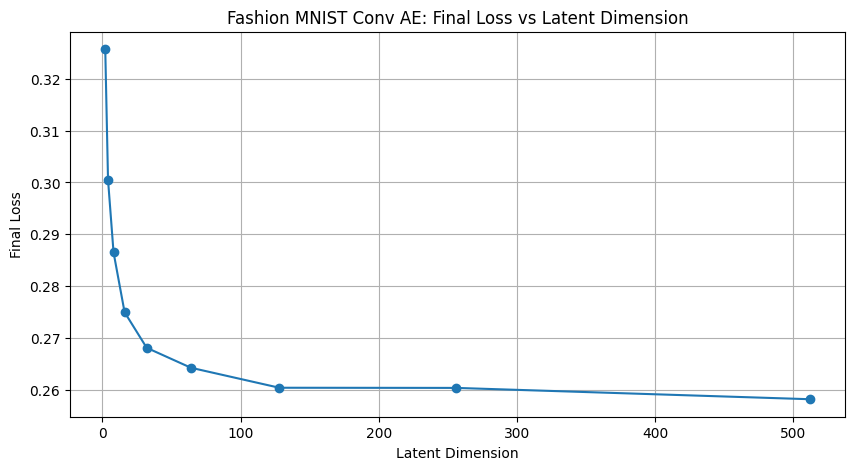

In [24]:
# plot loss
plt.figure(figsize=(10, 5))
plt.plot(latent_dims_list, last_test_loss_FMNIST_ConvAE, marker='o')
plt.title(f'Fashion MNIST Conv AE: Final Loss vs Latent Dimension')
plt.xlabel('Latent Dimension')
plt.ylabel('Final Loss')
plt.grid(True)
plt.show()

### VAE training

In [18]:
latent_dims_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]
last_test_loss_FMNIST_vae = []
for dim in latent_dims_list:
    last_loss = 0
    vae = VariationalAutoencoder(latent_dim=dim).to(device)
    optimizer_vae = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5) # setup an Adam optimizer using predefined lr, and a weight decay of 1e-5.
    optimizer_conv_AE = torch.optim.Adam(conv_AE.parameters(), lr=0.001)
    for epoch in range(30):
        vae.train()
        total_loss = 0
        for data in train_dataloader:
            img, _ = data  # Assuming labels are not used
            img = img.to(device)
            image_batch_recon, latent_mu, latent_logvar = vae(img)
            loss = vae_loss(image_batch_recon, img, latent_mu, latent_logvar)

            optimizer_vae.zero_grad()
            loss.backward()
            optimizer_vae.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)/batch_size

        vae.eval()
        test_loss_VAE = 0
        # No need to track gradients in test mode
        with torch.no_grad():
            for data in test_dataloader:
                img, label = data
                img = img.to(device)
                output,latent_mu,latent_logvar = vae(img)
                loss = vae_loss(output, img, latent_mu, latent_logvar)
                test_loss_VAE += loss

            # Compute the average test loss
            test_loss_VAE = test_loss_VAE / len(test_dataloader)/10000
            test_loss_VAE = test_loss_VAE.item()
            last_loss = test_loss_VAE
        print(f'Epoch: {epoch+1}, Train Loss: {average_loss:.4f}, Test Loss: {test_loss_VAE:.4f}')
    last_test_loss_FMNIST_vae.append(last_loss)
    print('last test loss is',last_loss)

Epoch: 1, Train Loss: 324.2707, Test Loss: 280.3736
Epoch: 2, Train Loss: 276.5796, Test Loss: 274.0928
Epoch: 3, Train Loss: 272.3765, Test Loss: 271.5959
Epoch: 4, Train Loss: 270.0806, Test Loss: 270.5482
Epoch: 5, Train Loss: 268.4201, Test Loss: 268.9791
Epoch: 6, Train Loss: 267.2793, Test Loss: 267.4545
Epoch: 7, Train Loss: 266.2853, Test Loss: 266.3706
Epoch: 8, Train Loss: 265.6122, Test Loss: 265.7506
Epoch: 9, Train Loss: 264.9957, Test Loss: 265.5605
Epoch: 10, Train Loss: 264.5416, Test Loss: 265.7437
Epoch: 11, Train Loss: 264.1351, Test Loss: 264.7418
Epoch: 12, Train Loss: 263.7883, Test Loss: 264.2420
Epoch: 13, Train Loss: 263.3802, Test Loss: 264.9254
Epoch: 14, Train Loss: 263.1625, Test Loss: 263.5821
Epoch: 15, Train Loss: 262.8458, Test Loss: 264.0074
Epoch: 16, Train Loss: 262.6236, Test Loss: 263.4434
Epoch: 17, Train Loss: 262.3814, Test Loss: 263.5370
Epoch: 18, Train Loss: 262.1404, Test Loss: 263.5567
Epoch: 19, Train Loss: 261.8664, Test Loss: 262.8529
Ep

In [19]:
# save loss
path = "./loss_data"
if not os.path.exists(path): os.mkdir(path)
with open(f'{path}/last_test_loss_FMNIST_vae.pkl', 'wb') as f:
    pickle.dump(last_test_loss_FMNIST_vae, f)

In [20]:
# read loss
with open(f'{path}/last_test_loss_FMNIST_vae.pkl', 'rb') as f:
    last_test_loss_FMNIST_vae = pickle.load(f)

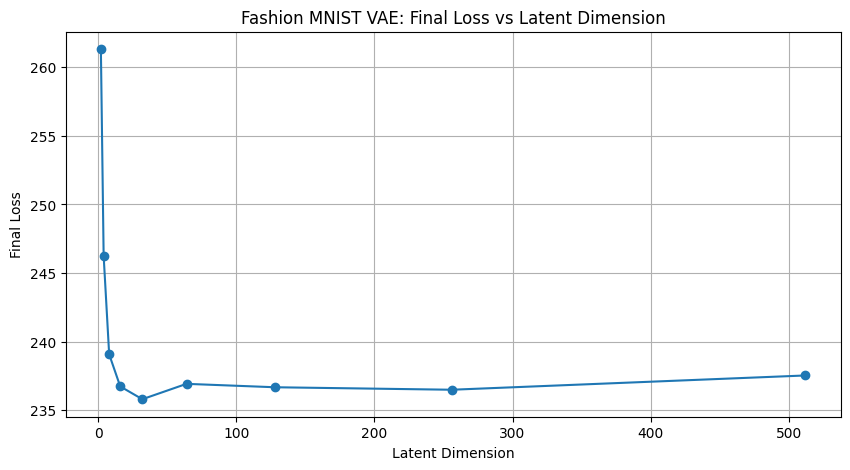

In [21]:
# plot loss
plt.figure(figsize=(10, 5))
plt.plot(latent_dims_list, last_test_loss_FMNIST_vae, marker='o')
plt.title(f'Fashion MNIST VAE: Final Loss vs Latent Dimension')
plt.xlabel('Latent Dimension')
plt.ylabel('Final Loss')
plt.grid(True)
plt.show()